# Решение задачи бинарной классификации

Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn import svm
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

Загружаем датасет [Fitness Club Dataset for ML Classification](https://www.kaggle.com/datasets/ddosad/datacamps-data-science-associate-certification)

In [2]:
df = pd.read_csv('https://drive.google.com/uc?id=1v8Kt_G1uF0qF4dq4pF56PLdg6YhNhzLP', index_col=0)
df.head()

,months_as_member,weight,days_before,day_of_week,time,category,attended
booking_id,,,,,,,
1,17,79.56,8,Wed,PM,Strength,0
2,10,79.01,2,Mon,AM,HIIT,0
3,16,74.53,14,Sun,AM,Strength,0
4,5,86.12,10,Fri,AM,Cycling,0
5,15,69.29,8,Thu,AM,HIIT,0


# 1. Предобработка данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 1 to 1500
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   months_as_member  1500 non-null   int64  
 1   weight            1480 non-null   float64
 2   days_before       1500 non-null   object 
 3   day_of_week       1500 non-null   object 
 4   time              1500 non-null   object 
 5   category          1500 non-null   object 
 6   attended          1500 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 93.8+ KB


Хотим работать с 'days_before' как с целочисленными значениями, попытаемся перевести тип данных:

(расскомментировав будет ошибка)

In [4]:
#df['days_before'] = df['days_before'].astype(int)

In [5]:
def clean_from_days(s):
  if s:
    return s.split(maxsplit=1)[0]
  else:
    return


df['days_before'] = df['days_before'].apply(clean_from_days)

In [6]:
df['days_before'] = df['days_before'].astype(int)

Теперь получилось

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 1 to 1500
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   months_as_member  1500 non-null   int64  
 1   weight            1480 non-null   float64
 2   days_before       1500 non-null   int64  
 3   day_of_week       1500 non-null   object 
 4   time              1500 non-null   object 
 5   category          1500 non-null   object 
 6   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 93.8+ KB


Почистим категориальные данные

In [8]:
df['day_of_week'].unique()

array(['Wed', 'Mon', 'Sun', 'Fri', 'Thu', 'Wednesday', 'Fri.', 'Tue',
       'Sat', 'Monday'], dtype=object)

In [9]:
df['day_of_week'] = df['day_of_week'].replace({'Fri.': 'Fri', 'Wednesday': 'Wed', 'Monday':'Mon'})
df['day_of_week'].unique()

array(['Wed', 'Mon', 'Sun', 'Fri', 'Thu', 'Tue', 'Sat'], dtype=object)

In [10]:
df['time'].unique()

array(['PM', 'AM'], dtype=object)

In [11]:
df['category'].unique()

array(['Strength', 'HIIT', 'Cycling', 'Yoga', '-', 'Aqua'], dtype=object)

In [12]:
df['category'] = df['category'].replace({'-': None})
df['category'].unique()

array(['Strength', 'HIIT', 'Cycling', 'Yoga', None, 'Aqua'], dtype=object)

Статистика для численных данных

In [13]:
df.describe()

,months_as_member,weight,days_before,attended
count,1500.000000,1480.000000,1500.000000,1500.000000
mean,15.628667,82.610378,8.346667,0.302667
std,12.926543,12.765859,4.077938,0.459565
min,1.000000,55.410000,1.000000,0.000000
25%,8.000000,73.490000,4.000000,0.000000
50%,12.000000,80.760000,9.000000,0.000000
75%,19.000000,89.520000,12.000000,1.000000
max,148.000000,170.520000,29.000000,1.000000


Статистика для категориальных данных

In [14]:
df.describe(include='object')

,day_of_week,time,category
count,1500,1500,1487
unique,7,2,5
top,Fri,AM,HIIT
freq,305,1141,667


В датафрейм добавились None'ы  (в колонку category):

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 1 to 1500
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   months_as_member  1500 non-null   int64  
 1   weight            1480 non-null   float64
 2   days_before       1500 non-null   int64  
 3   day_of_week       1500 non-null   object 
 4   time              1500 non-null   object 
 5   category          1487 non-null   object 
 6   attended          1500 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 93.8+ KB


# 2. Визуализация данных

Сначала рассмотрим возможные варианты визуализации для одного численного параметра (months_as_member):

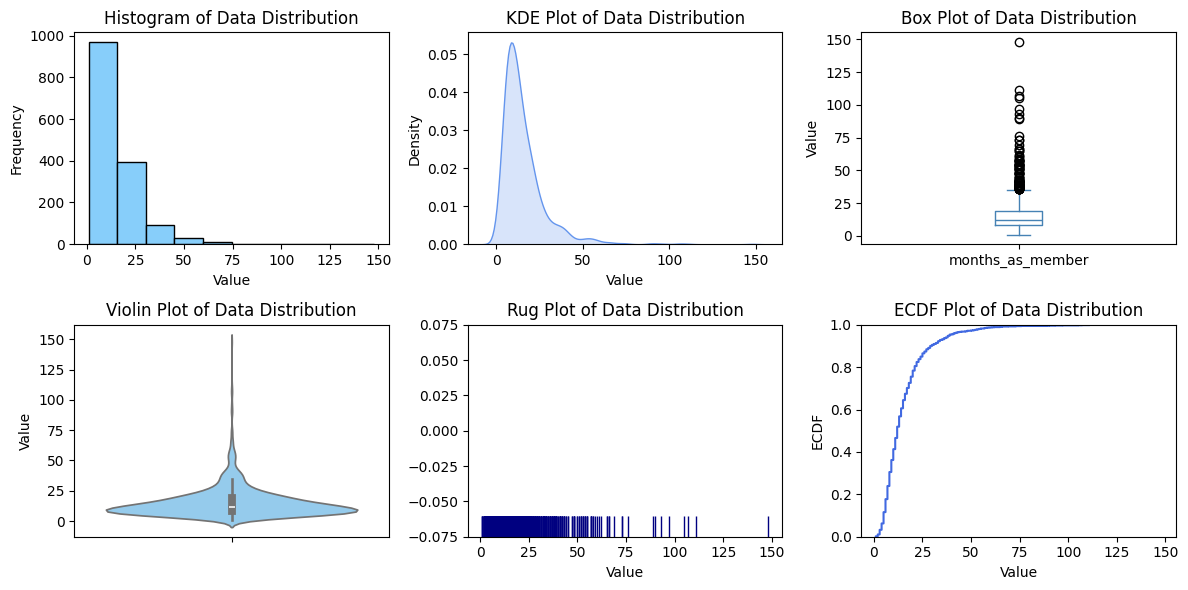

In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
df.months_as_member.plot(kind='hist', bins=10, title='Histogram of Data Distribution', color='lightskyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
sns.kdeplot(df.months_as_member, fill=True, color='cornflowerblue')
plt.title('KDE Plot of Data Distribution')
plt.xlabel('Value')
plt.ylabel('Density')

plt.subplot(2, 3, 3)
df.months_as_member.plot(kind='box', title='Box Plot of Data Distribution', color='steelblue')
plt.ylabel('Value')

plt.subplot(2, 3, 4)
sns.violinplot(y=df.months_as_member, color='lightskyblue')
plt.title('Violin Plot of Data Distribution')
plt.ylabel('Value')

plt.subplot(2, 3, 5)
sns.rugplot(df.months_as_member, height=0.1, color='navy')
plt.title('Rug Plot of Data Distribution')
plt.xlabel('Value')

plt.subplot(2, 3, 6)
sns.ecdfplot(df.months_as_member, color='royalblue')
plt.title('ECDF Plot of Data Distribution')
plt.xlabel('Value')
plt.ylabel('ECDF')

plt.tight_layout()
plt.show()

Для рассмотренния по всем численным данным выберем гистограмму и боксы:

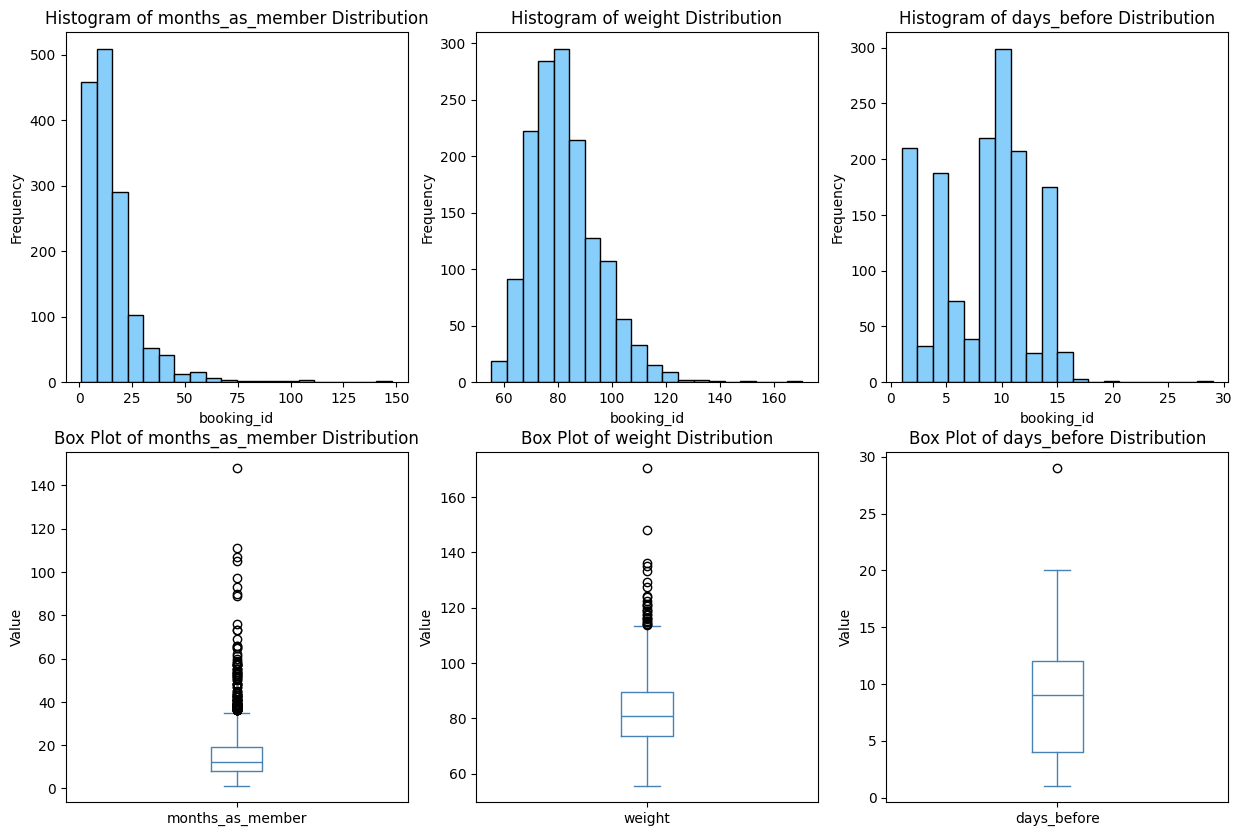

In [17]:
numerical_params = list(df.select_dtypes(['int64', 'float64']).columns)

fig, axes = plt.subplots(2, len(numerical_params)-1, figsize=(15, 10))

for param in numerical_params[:-1]:
  ind = numerical_params.index(param)
  df[param].plot(ax=axes[0, ind], kind='hist', bins=20, title=f'Histogram of {param} Distribution', color='lightskyblue', edgecolor='black', xlabel='booking_id', ylabel='Frequency')
  df[param].plot(ax=axes[1, ind], kind='box', title=f'Box Plot of {param} Distribution', ylabel='Value', color='steelblue')

По второму ряду видно, что по численным признакам имеются выбросы.

Распределение по категориальным данным:

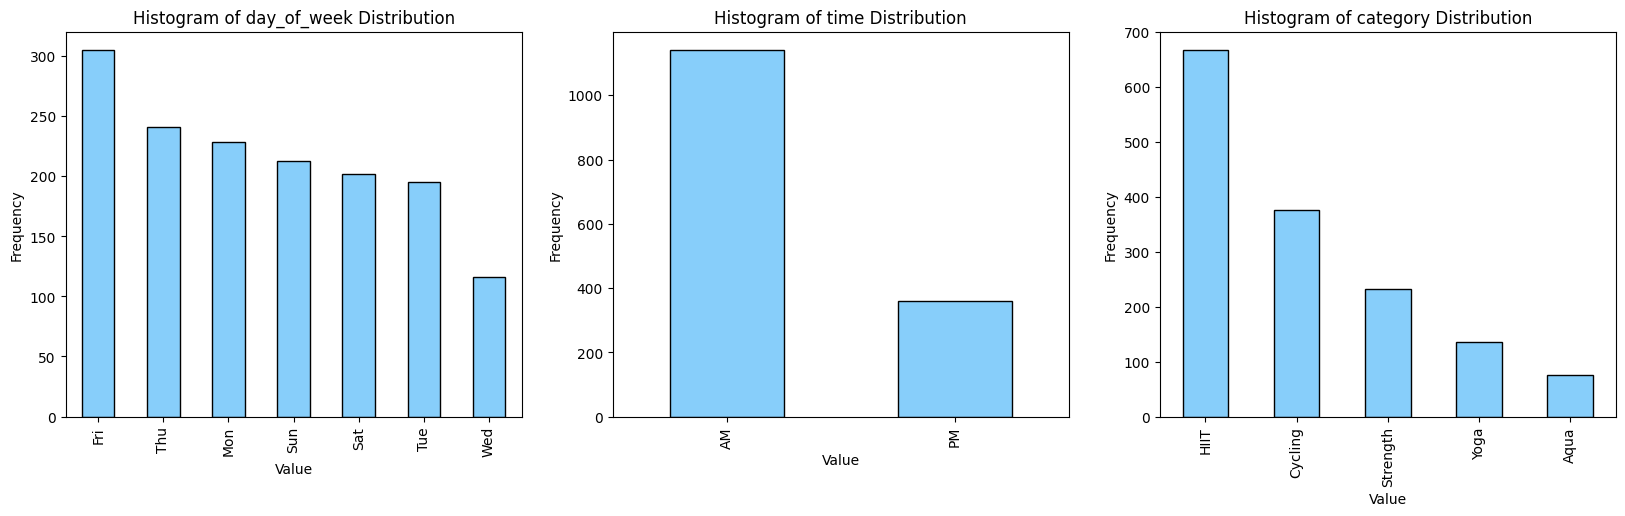

In [18]:
categorial_params = list(df.select_dtypes(['object']).columns)

fig, axes = plt.subplots(1, len(categorial_params), figsize=(20, 5))

for param in categorial_params:
  ind = categorial_params.index(param)
  df[param].value_counts().plot(ax=axes[ind], kind='bar',  title=f'Histogram of {param} Distribution', color='lightskyblue', edgecolor='black', xlabel='Value', ylabel='Frequency')

Распределение классов в датасете


<Axes: ylabel='count'>

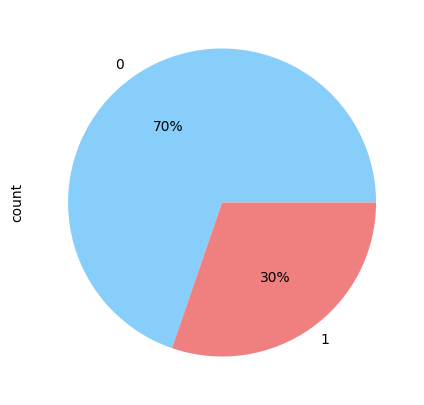

In [19]:
df['attended'].value_counts().plot.pie(figsize=(5, 5), colors=['lightskyblue', 'lightcoral'], autopct='%1.0f%%')

Кодируем категориальные данные с помощью LabelEncoder'а

In [20]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df_label_encod = df.copy()

for param in categorial_params:
  df_label_encod[param]= label_encoder.fit_transform(df_label_encod[param])

df_label_encod.head()

,months_as_member,weight,days_before,day_of_week,time,category,attended
booking_id,,,,,,,
1,17,79.56,8,6,1,3,0
2,10,79.01,2,1,0,2,0
3,16,74.53,14,3,0,3,0
4,5,86.12,10,0,0,1,0
5,15,69.29,8,4,0,2,0


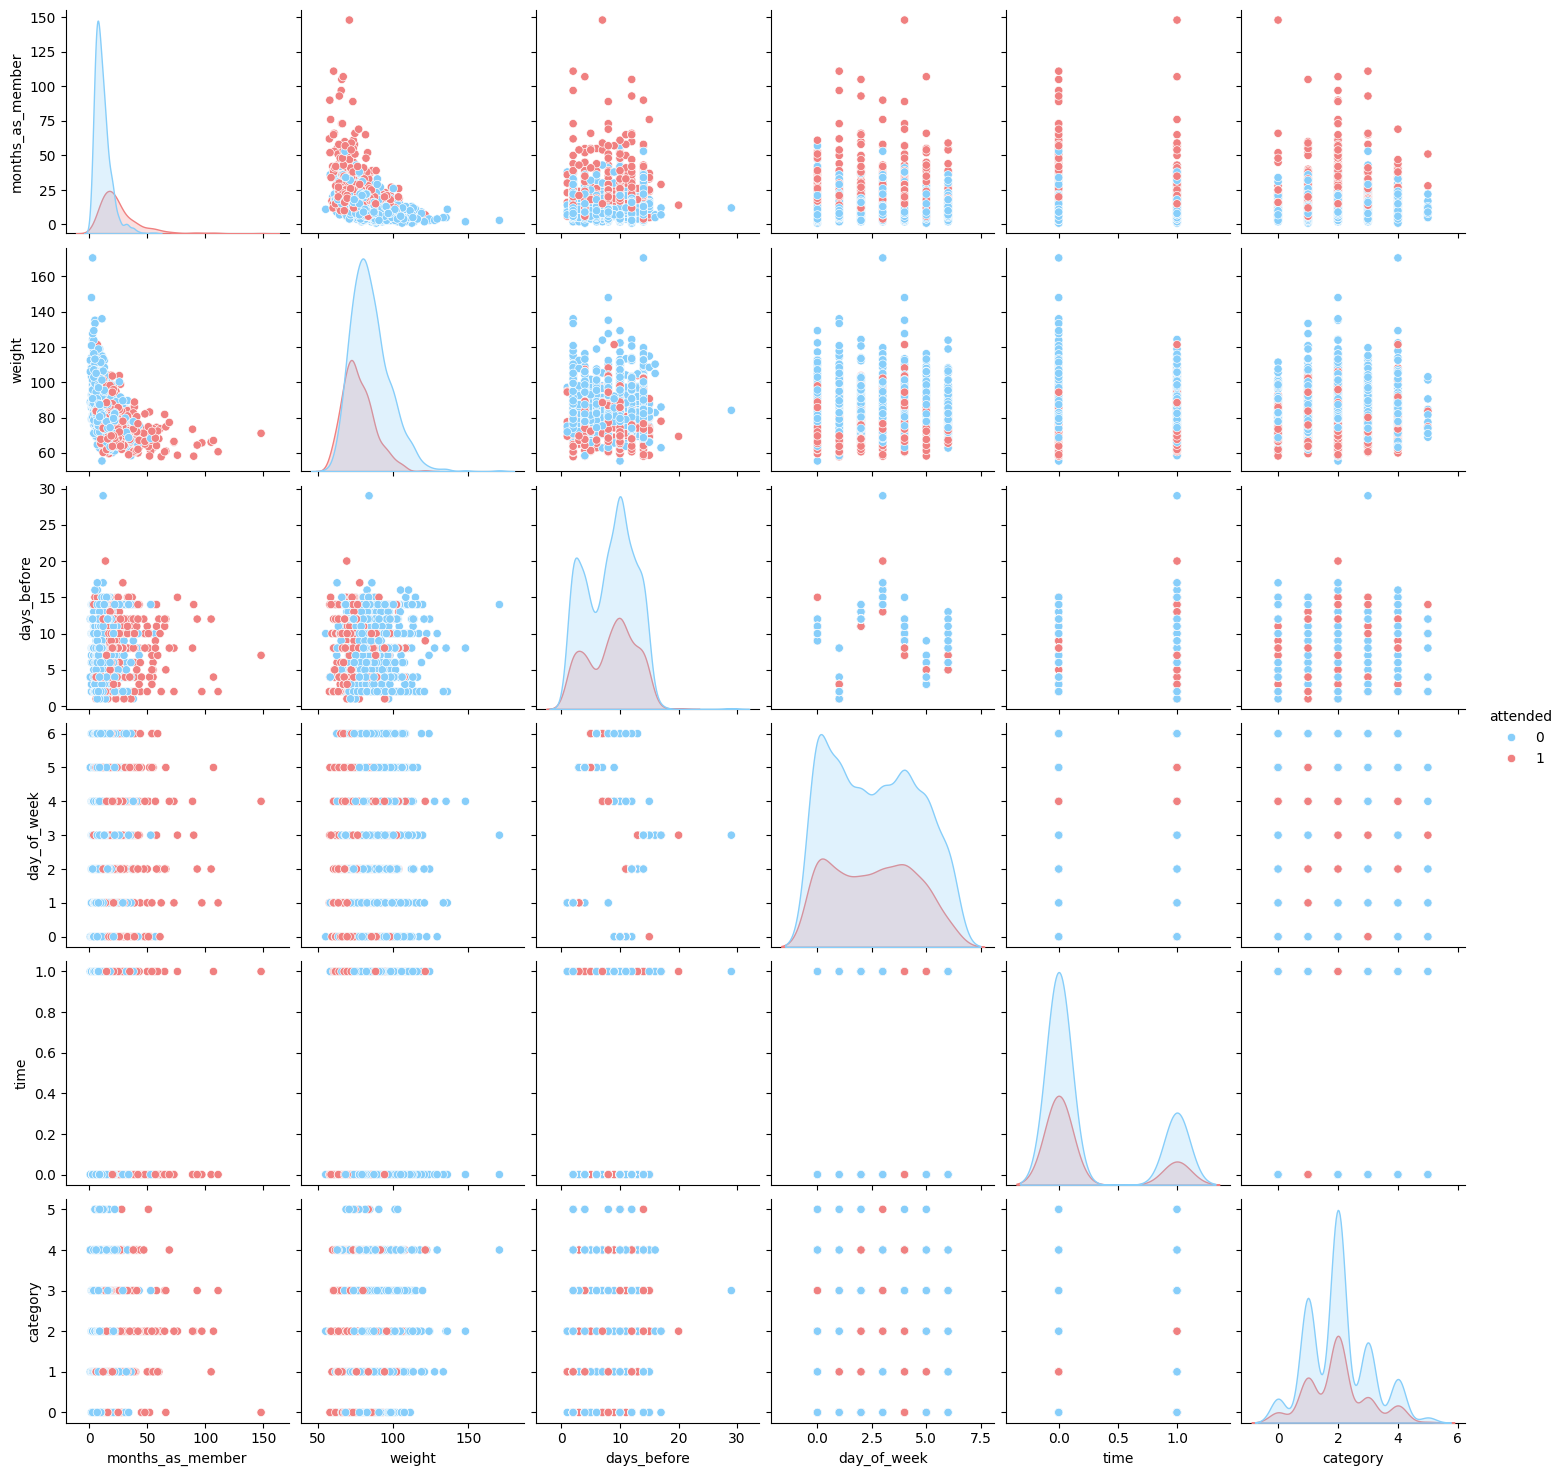

In [21]:
sns.pairplot(df_label_encod, hue="attended", palette=['lightskyblue', 'lightcoral'])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, 'months_as_member'),
  Text(1.5, 0, 'weight'),
  Text(2.5, 0, 'days_before'),
  Text(3.5, 0, 'day_of_week'),
  Text(4.5, 0, 'time'),
  Text(5.5, 0, 'category'),
  Text(6.5, 0, 'attended')])

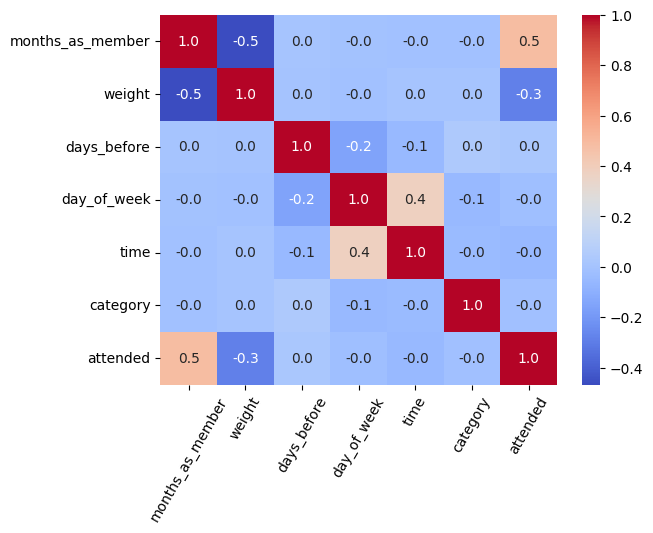

In [22]:
sns.heatmap(df_label_encod.corr(), annot=True, fmt=".1f", cmap="coolwarm")
plt.xticks(rotation=60)

Видно, что коэффициенты корреляции между признаками лежат в приделах нормы (от -0.5 до 0.5).

# 3. Работа с искажениями

В пункте 1 уже рассмотрены уникальные значения категориальных данных, они нас устраивают. Также выполнен перевод колонки 'days_before' в целочисленный вид.

Проверим, что колонки 'months_as_member', 'weight', 'days_before' содержат положительные значения:

In [23]:
df_no_missing = df.dropna()

print(f"months_as_member is correct - {(df_no_missing['months_as_member'] > 0).all()}")
print(f"weight is correct - {(df_no_missing['weight'] > 0).all()}")
print(f"days_before is correct - {(df_no_missing['days_before'] > 0).all()}")

months_as_member is correct - True
weight is correct - True
days_before is correct - True


Проверка на дубликаты:

In [24]:
print(len(df[df.duplicated()]))

1


В данном случае удаление дубликатов корректно, поскольку две строки с одинаковым booking_id содеражт информацию об одном и том же человеке

In [25]:
df = df.drop_duplicates()

Заполнение пропусков медианным значением

In [26]:
columns_with_missings = df.columns[df.isnull().any()]

for column in columns_with_missings:
  df[column].fillna(df[column].mode()[0], inplace=True)

<ipython-input-26-d2af02c097ff>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)
<ipython-input-26-d2af02c097ff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].fillna(df[column].mode()[0], inplace=True)


Убедимся, что во всех столбцах ноль пустых значений

In [27]:
df.isnull().sum()

,0
months_as_member,0
weight,0
days_before,0
day_of_week,0
time,0
category,0
attended,0


In [28]:
df.shape

(1499, 7)

Удаление выбросов методом межквартильного размаха (IQR)

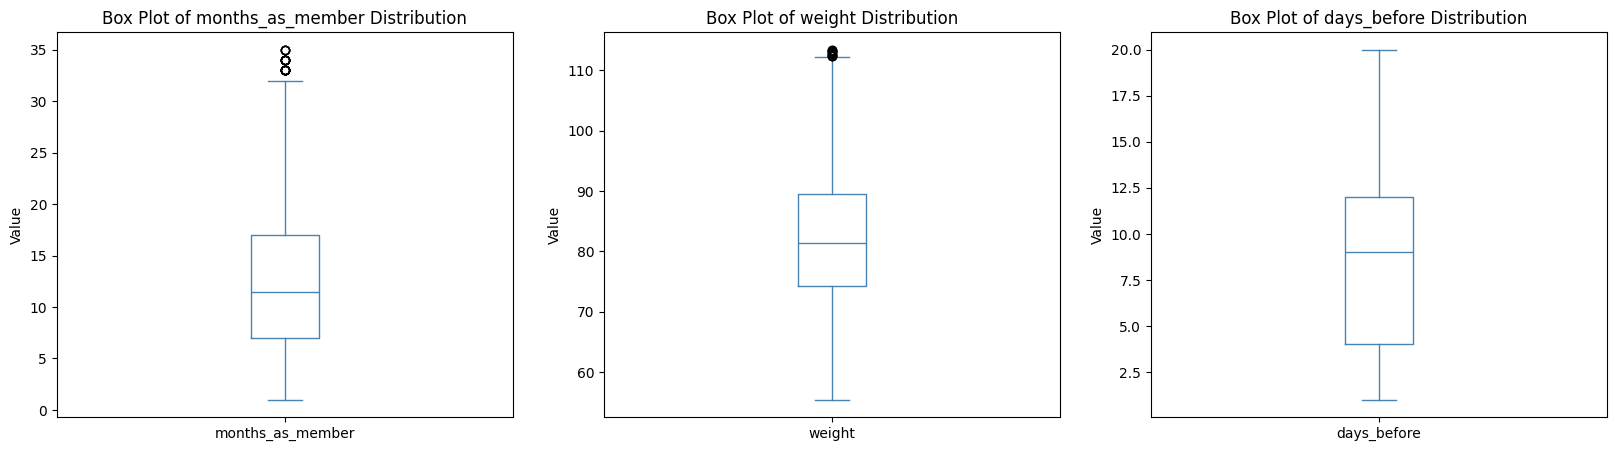

In [29]:
fig, axes = plt.subplots(1, len(numerical_params)-1, figsize=(20, 5))

for param in numerical_params[:-1]:
  q1 = df[param].quantile(0.25)
  q3 = df[param].quantile(0.75)
  iqr = q3 - q1
  df = df[(df[param] < q3 + 1.5 * iqr) & (df[param] > q1 - 1.5 * iqr)]
  ind = numerical_params.index(param)
  df[param].plot(ax=axes[ind], kind='box', title=f'Box Plot of {param} Distribution', ylabel='Value', color='steelblue')
plt.show()

In [30]:
df.shape

(1369, 7)

# 4. Кодирование категориальных данных (one-hot-encoding)

In [31]:
df_pandas_encoded = pd.get_dummies(df, columns=categorial_params, drop_first=True)
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorial_params])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorial_params))
one_hot_df.index = df.drop(categorial_params, axis=1).index
df_encoded = pd.concat([df.drop(categorial_params, axis=1), one_hot_df], axis=1)
df_encoded

,months_as_member,weight,days_before,attended,day_of_week_Fri,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,time_AM,time_PM,category_Aqua,category_Cycling,category_HIIT,category_Strength,category_Yoga
booking_id,,,,,,,,,,,,,,,,,,
1,17,79.56,8,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,10,79.01,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16,74.53,14,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,86.12,10,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,15,69.29,8,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,21,79.51,10,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1497,29,89.55,2,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1498,9,87.38,4,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# 5. Масштабирование данных

Масштабирование данных необходимо, поскольку алгоритмы обучения чувствительны к диапазонам значений признаков. То есть, если один признак измеряется от единицах, а другой в сотнях тысячах, то модель будет перетягивать внимание на признаки с большим диапазоном, заведомо считая их вклад в модель больше.

In [32]:
changing = df_encoded[['months_as_member',	'weight',	'days_before']]
unchanging = df_encoded.drop(['months_as_member',	'weight',	'days_before'], axis=1)

**Нормализация данных**\
Для каждого столбца выполним преобразование: $x = \cfrac{x - x_{min}}{x_{max}-x_{min}}$, после которого все данные будут в диапазоне [0, 1]

In [33]:
mms = MinMaxScaler()
mms.fit(changing)

changing_norm = pd.DataFrame(mms.transform(changing), columns=changing.columns)

In [34]:
changing_norm.describe()

,months_as_member,weight,days_before
count,1369.000000,1369.000000,1369.000000
mean,0.357474,0.469744,0.385760
std,0.212786,0.193616,0.213052
min,0.000000,0.000000,0.000000
25%,0.205882,0.325982,0.157895
50%,0.323529,0.446416,0.421053
75%,0.500000,0.588043,0.578947
max,1.000000,1.000000,1.000000


In [35]:
unchanging.index = changing_norm.index
df_norm = pd.concat([changing_norm, unchanging], axis=1)

**Стандартизация данных**\
Приведение данных к нормальному распределению с помощью преобразования: $x = \cfrac{x-x_{mean}}{std}$, после которого среднее значение будет в нуле, а стандартное отклонение равно единице.

In [36]:
scaler = StandardScaler()
scaler.fit(changing)

changing_std = pd.DataFrame(scaler.transform(changing), columns=changing.columns)

In [37]:
pd.set_option('display.float_format', lambda x: '%0.4f' % x)
changing_std.describe()

,months_as_member,weight,days_before
count,1369.0000,1369.0000,1369.0000
mean,0.0000,0.0000,-0.0000
std,1.0004,1.0004,1.0004
min,-1.6806,-2.4270,-1.8113
25%,-0.7127,-0.7428,-1.0699
50%,-0.1596,-0.1205,0.1657
75%,0.6701,0.6112,0.9071
max,3.0207,2.7397,2.8841


In [38]:
unchanging.index = changing_std.index
df_std = pd.concat([changing_std, unchanging], axis=1)

# 6. Обучение модели


In [39]:
y = df_encoded['attended']
X = df_encoded.drop(['attended'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1095, 17), (1095,), (274, 17), (274,))

In [40]:
y_norm = df_norm['attended']
X_norm = df_norm.drop(['attended'], axis=1)
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size = 0.2, random_state = 0)
X_norm_train.shape, y_norm_train.shape, X_norm_test.shape, y_norm_test.shape

((1095, 17), (1095,), (274, 17), (274,))

In [41]:
y_std = df_std['attended']
X_std = df_std.drop(['attended'], axis=1)
X_std_train, X_std_test, y_std_train, y_std_test = train_test_split(X_std, y_std, test_size = 0.2, random_state = 0)
X_std_train.shape, y_std_train.shape, X_std_test.shape, y_std_test.shape

((1095, 17), (1095,), (274, 17), (274,))

## 6.1 Логистическая регрессия

In [42]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Training set score: 0.7635
Test set score: 0.7956


In [43]:
logreg_norm = LogisticRegression(solver='liblinear')
logreg_norm.fit(X_norm_train, y_norm_train)

print('Training set score: {:.4f}'.format(logreg_norm.score(X_norm_train, y_norm_train)))
print('Test set score: {:.4f}'.format(logreg_norm.score(X_norm_test, y_norm_test)))

Training set score: 0.7598
Test set score: 0.7920


In [44]:
logreg_std = LogisticRegression(solver='liblinear')
logreg_std.fit(X_std_train, y_std_train)

print('Training set score: {:.4f}'.format(logreg_std.score(X_std_train, y_std_train)))
print('Test set score: {:.4f}'.format(logreg_std.score(X_std_test, y_std_test)))

Training set score: 0.7635
Test set score: 0.7920


Логистическая модель относится к вероятностным классификатором. Вероятность принадлежности объекта к положительному классу определяется линейной функцией, поэтому модель является **регрессией**. Поэтому данная модель должна быть чувствительна к масштабу данных (веса в линейной функции и диапазоны значений признаков тесно связаны), результаты метрики score подтверждают данные рассуждения. \
Можем сделать вывод, что для данного датасета диапазоны важны, поскольку нормирование приводит к снижению качества модели (по метрике score).\
Логистическая регрессия применима для данных с распределением Бернулли, поэтому стандартизация, приводящая к Гауссовому распределению, снижает качество модели. Результаты score подтверждают это.

## 6.2 Метод опорных векторов

In [45]:
svm_clf = LinearSVC()
svm_clf.fit(X_train, y_train)

print('Training set score: {:.4f}'.format(svm_clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(svm_clf.score(X_test, y_test)))

Training set score: 0.7626
Test set score: 0.7883


In [46]:
svm_clf_norm = LinearSVC()
svm_clf_norm.fit(X_norm_train, y_norm_train)

print('Training set score: {:.4f}'.format(svm_clf_norm.score(X_norm_train, y_norm_train)))
print('Test set score: {:.4f}'.format(svm_clf_norm.score(X_norm_test, y_norm_test)))

Training set score: 0.7616
Test set score: 0.7883


In [47]:
svm_clf_std = LinearSVC()
svm_clf_std.fit(X_std_train, y_std_train)

print('Training set score: {:.4f}'.format(svm_clf_std.score(X_std_train, y_std_train)))
print('Test set score: {:.4f}'.format(svm_clf_std.score(X_std_test, y_std_test)))

Training set score: 0.7626
Test set score: 0.7883


В данном случае получился интересный результат. При работе с SVM всегда нужно проводить нормироавние и стандартизацию данных, поскольку данный метод работает с расстояниями (как, например, и KNN). Но здесь масштабирование не повлияло на качество модели, что может говорить об изначальной хорошей разделимости данных.

Интересно попробовать с другим ядром:

In [48]:
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.fit(X_train, y_train)

print('Training set score: {:.4f}'.format(rbf_svc.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(rbf_svc.score(X_test, y_test)))

Training set score: 0.7498
Test set score: 0.7883


Score не изменилась

## 6.3 Случайный лес


In [49]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(X_train, y_train)

print('Training set score: {:.4f}'.format(rnd_clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(rnd_clf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.7920


In [50]:
rnd_clf_norm = RandomForestClassifier()
rnd_clf_norm.fit(X_norm_train, y_norm_train)

print('Training set score: {:.4f}'.format(rnd_clf_norm.score(X_norm_train, y_norm_train)))
print('Test set score: {:.4f}'.format(rnd_clf_norm.score(X_norm_test, y_norm_test)))

Training set score: 1.0000
Test set score: 0.7847


In [51]:
rnd_clf_std = RandomForestClassifier()
rnd_clf_std.fit(X_std_train, y_std_train)

print('Training set score: {:.4f}'.format(rnd_clf_std.score(X_std_train, y_std_train)))
print('Test set score: {:.4f}'.format(rnd_clf_std.score(X_std_test, y_std_test)))

Training set score: 1.0000
Test set score: 0.7920


Training set score: 1 следует из построения.\
Вобще говоря, слуйчаный лес (как и его ребенок - дерево решений) не чувствительны к масштабу, поскольку при построении модели важны не абсолютные, а относительные значения (само дерево - ветви и листья - не меняются, меняется условие в узлах). \
Однако в случае наличия признаков, которые имеют высокую корреляцию, но находятся в разных диапазонах, масштабирование может повысить качество алгоритма. В данном случае [коррелируют](https://colab.research.google.com/drive/1upLaUxHAV2XZrpa7EPFxxxNqQ6FRhGpE#scrollTo=-2yjQUc877Tb&line=1&uniqifier=1) признаки 'month_as_member' и 'weight', поэтому нормировка и стандартизация нивелировала это свойство датасета и сдвинуло score в сторону единицы.


Лучше всего себя проявила модель логистической регрессии, продолжим работу с ней. Другие метрики модели:

In [52]:
for score in ["accuracy", "precision", "recall"]:
    print(f'{score}:{cross_val_score(logreg, X_train, y_train,scoring=score, cv=10).mean()}')

accuracy:0.7607256046705587
precision:0.600995115995116
recall:0.34034482758620693


Матрица ошибок

In [53]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # set matrix values
    thresh = cm.max() / 2.
    tags = [['TP', 'FN'], ['FP', 'TN']]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      message = f'{tags[i][j]}\n{cm[i, j]}'
      plt.text(j, i, message,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real')
    plt.xlabel('Predicted')
    plt.tight_layout()

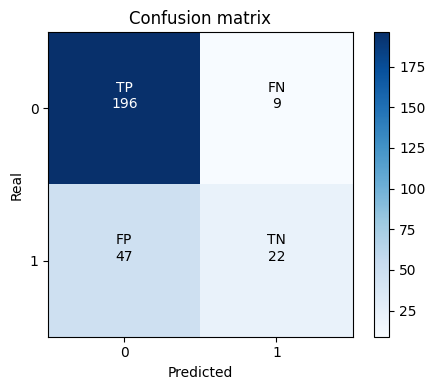

In [54]:
pred_test = logreg.predict(X_test)
cnf_matrix = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'])

ROC-Curve

In [55]:
def plot_roc_curve(y_test, probs):
  plt.figure(figsize=(5, 4))
  lr_auc = roc_auc_score(y_test, probs)
  fpr, tpr, treshold = roc_curve(y_test, probs)
  plt.plot(fpr, tpr, label=f"AUC= {str(round(lr_auc, 6))}", color='red')
  plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC-кривая')
  plt.legend()
  plt.show()

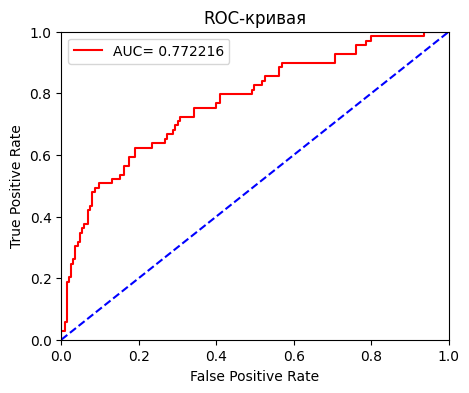

In [56]:
logreg_probs = logreg.predict_proba(X_test)
logreg_probs = logreg_probs[:, 1]
plot_roc_curve(y_test, logreg_probs)

# 7. Понижение размерности

## 7.1 Регуляризация

$N$ - количество объектов в обучающей выборке, $n$ - количество признаков, $a_{i}$ - веса в модели

Функция потерь\
$L = \sum_{i=1}^{N} ((y_i - y(\overline{x_i}) ^ 2+ λg(a))$\
λ - коэффициент регуляризации, $λg(a)$ - регуляризационный член \
**$L1$ (Lasso Regression) регуляризация:** $g(a) = \sum_{i=1}^{n}|a_i|$\
**$L2$ (Ridge Regression) регуляризация:** $g(a) = \sum_{i=1}^{n}a_i^2$

Для логистической регрессии параметр регуляризации по умолчанию l2 (penalty='l2'). Рассмотри случай l1:

In [57]:
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Training set score: 0.7644
Test set score: 0.7956


Score не изменилась. Ожидаемо, поскольку разница заметна на высокоразмерных датасетах, а в данной выборке < 1500 объектов.

## 7.2 Последовательный отбор признаков

Воспользуемся методом RFE (Recursive Feature Elimination), поскольку он показывает хорошие результаты в работе с логистической регрессией.\
Найдем такое количество признаков, которое почти не скажется на метрике score.

In [59]:
for n_features in range(1, X_train.shape[1] + 1):
        rfe = RFE(estimator=logreg, n_features_to_select=n_features)
        rfe.fit(X_train, y_train)

        X_train_selected = rfe.transform(X_train)
        X_test_selected = rfe.transform(X_test)

        logreg.fit(X_train_selected, y_train)
        y_pred = logreg.predict(X_test_selected)

        score = logreg.score(X_test_selected, y_test)
        if score > 0.7956:
            print("n features:", n_features)
            print("selected features:", ", ".join(list(X_train.columns[rfe.support_])))
            break

n features: 10
selected features: months_as_member, weight, day_of_week_Sun, day_of_week_Thu, day_of_week_Wed, time_PM, category_Aqua, category_HIIT, category_Strength, category_Yoga


Это очень хороший результат, поскольку мы не проиграли в score, но почти в два раза (18->10) уменьшили размерность датасета.

## 7.3 Дерево решений

Ищем минимальное количество признаков, которые обеспечат score в пределах 5% от стартового значения

In [60]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

feature_importances = tree.feature_importances_
selected_features = np.arange(X_train.shape[1])
current_score = tree.score(X_test, y_test)
score_0 = current_score
print('start_score:', score_0)
while current_score >= 0.95 * score_0 and len(selected_features) > 1:
    importance_scores = feature_importances[selected_features]
    least_important_feature = selected_features[np.argmin(importance_scores)]
    selected_features = selected_features[selected_features != least_important_feature]

    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    tree.fit(X_train_selected, y_train)
    current_score = tree.score(X_test_selected, y_test)

print("n features:", len(selected_features))
print('selected features:', X_train.columns[selected_features].tolist())

start_score: 0.7664233576642335
n features: 6
selected features: ['months_as_member', 'weight', 'days_before', 'day_of_week_Tue', 'category_Cycling', 'category_HIIT']


Данный способ понижения размерности тоже показывает хорошую производительность, посколько снежение score на 5% позволяет снизить размерность датасета в 3 раза!